# Investigate false predictions:

- What differentiates FN from TP women?
- How similar are FN women to TP men?


**Method**:
- divide into FN/FP women and TP men
- do univariate tests for each variable to see where populations differ


--> Idea is to understand what makes the model misclassify to derive the clinical picture of a "typical MG women"



In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append(f"{PATH}/scripts")

from func_preprocess import read_data, subset_wo_missigness, remove_NA, parseVariables, clean_data, impute_scale 

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import ttest_ind, chi2_contingency, false_discovery_control, mannwhitneyu
import pickle



sns.set_theme(style="white", font_scale=1.5, context="paper") #palette=sns.husl_palette(n_colors=8)

In [2]:
def stat_continous(df_allVars_tp, df_allVars_fn, voi, test="mannwhitneyu", plot=True, colors=["gray", "green"]):

   ### make statistical test
    if test == "ttest":
        pVal = ttest_ind(df_allVars_tp[voi], df_allVars_fn[voi]).pvalue
    
    if test == "mannwhitneyu":
        pVal = mannwhitneyu(df_allVars_tp[voi], df_allVars_fn[voi], alternative='two-sided').pvalue
    
    ### Plot
    if plot:
        fig, ax = plt.subplots()
        df_plot = pd.concat([df_allVars_tp.loc[:,[voi, "class"]], df_allVars_fn.loc[:,[voi, "class"]]], axis=0)
        ax = sns.violinplot(data = df_plot, y=voi, hue="class", palette=colors)
        #ax.text(0, df_plot[voi].min()+df_plot[voi].min()/1.5, s='pVal = {:0.3e}'.format(pVal))
        plt.title(f"{voi}"+' (pVal={:0.2e})'.format(pVal))
        plt.show()
    return pVal

In [3]:
def stat_binary(df_allVars_tp, df_allVars_fn, voi, test="chi2", plot=True):
    from scipy.stats import chi2_contingency

    df_plot = pd.concat([df_allVars_tp.loc[:,[voi, "class"]], df_allVars_fn.loc[:,[voi, "class"]]], axis=0)
    conTab = pd.crosstab(df_plot[voi], df_plot["class"])
    np.matrix(conTab)

    ### make statistical test
    if test == "chi2":
        pVal = chi2_contingency(conTab).pvalue
    
    ### Plot
    if plot:
        custom_cmap = sns.color_palette("light:indianred", as_cmap=True)
        fig, ax = plt.subplots()
        sns.heatmap(conTab,  annot=True, fmt='.2f', cmap=custom_cmap)
        plt.title(f"{voi}"+' (pVal={:0.2e})'.format(pVal))
        plt.show()
    return pVal

## Read data

### Predictions

In [4]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
percentBoruta = 100
n_iter = 300

varSet = "fullRegistry"
varFolder = "boruta"
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    

# varSet = "fullRegistry"
# varFolder = "manual"
# vars = "partiallyValidated"

resultsPath = f"{PATH}/results/30_internalValidation/{varSet}/{vars}"
folderFigures = f"{PATH}/figures/30_internalValidation/{varSet}/{vars}"
folderFigures_publication = f"{PATH}/figures/publication/{varSet}"

os.makedirs(folderFigures, exist_ok=True)
''' 
Split data
'''
data = read_data(PATH,FILENAME=f"{varSet}")
X = data.drop(target, axis=1)
y = data[target]
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data_proba = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T
y_proba= data_proba.mean(axis=1).sort_index()
tru = y.loc[data_proba.index] 

df_pred = pd.concat([y_proba, tru], axis=1)
df_pred.columns = ['y_predProb', 'y_true']
df_pred

df_pred['y_predBinary'] = 0
df_pred['y_predBinary'][df_pred['y_predProb'] > 0.5] = 1



LOADING DATA


/tmp/ipykernel_2018243/3538321976.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['y_predBinary'][df_pred['y_predProb'] > 0.5] = 1


In [5]:
df_pred

,y_predProb,y_true,y_predBinary
002D7Y7Z,0.617728,1,1
002G71A3,0.316857,0,0
00C4EK1J,0.547126,0,1
01M51DX3,0.743350,0,1
02U71U3N,0.514271,1,1
...,...,...,...
ZWUVEM64,0.236854,0,0
ZXX7E4X4,0.510242,1,1
ZY91U2Q2,0.528403,1,1
ZZEHZKCR,0.680255,1,1


### Clinical data

In [6]:
''' 1. read data '''
data = read_data(PATH, FILENAME=f"{varSet}")

#######
var_subset_analysis = False   ### False     
#######
if var_subset_analysis: 
    data = subset_wo_missigness(data, var_subset_analysis)
data_clean = remove_NA(data, cutoff_perc=35)


vars2remove = pd.read_csv(f"{PATH}/data/variables_to_remove_fullRegistry.txt", header=None)[0].tolist()     
data_clean_parsed = parseVariables(data_clean, vars2remove)
print(data_clean_parsed.columns)

''' 
4. clean variables; e.g. MGFA classification
'''
data_clean_parsed = clean_data(data_clean_parsed)

''' 
5. impute and scale
`df_imputedScaled` = scaled dataset for clustering algorithm
`df_reverseTransform` = unscaled "normal" values for plotting - makes it easier to interpret plot
'''
df_imputedScaled, df_reverseTransform = impute_scale(data_clean_parsed, ohe_yn=False)
print(df_imputedScaled.shape)

'''
add PID back in
'''
df_imputedScaled.index = data_clean_parsed.index 
df_reverseTransform.index = data_clean_parsed.index 




LOADING DATA


REMOVING MISSINGNESS (cutoff=35%)
Keeping 35/40 variables
Discarded: ['testergebnisdekrement_rb', 'testergebnispyridostigmin_rb', 'lrp4antikoerper_rb', 'histologie_sprb', 'scoreqmg_neu']


REMOVING BIASING / UNWANTED VARIABLES
Discarded: ['age', 'age_bei_diagnose', 'scoreqol_neu', 'chronicfatigue_neu']
(1814, 31)
Index(['gender', 'zn_myasthener_krise_jn', 'zn_myasthener_exazerbation',
       'aktueller_mgfa_score', 'mgfaklassifikation_schlimmste_historisch_rb',
       'okulaer', 'bulbaer', 'generalisiertemuskelschwaeche', 'muskelschmerz',
       'autoimmunerkrankungen_rbzu', 'achrak_rb', 'antimuskak_rb',
       'thymektomie_gr', 'pyridostigmin_sprb', 'immuntherapie_grrb',
       'kortison_sprb', 'azathioprin_sprb', 'methotrexatfolsauure_sprb',
       'mycophenolatmofetil_sprb',
       'eskalationstherapiebeitherapierefraktaerermyasthenie_grrb',
       'eculizumab_sprb', 'rituximab_sprb', 'exazerbationstherapie_grrb',
       'plasmapherese_sprb', 'immunadsorption_sprb',



(1814, 31)


## Visualisation - density & confusion matrix

Text(0.5, 0.98, 'gender_bootstrapped_iterativeBoruta_100perc')

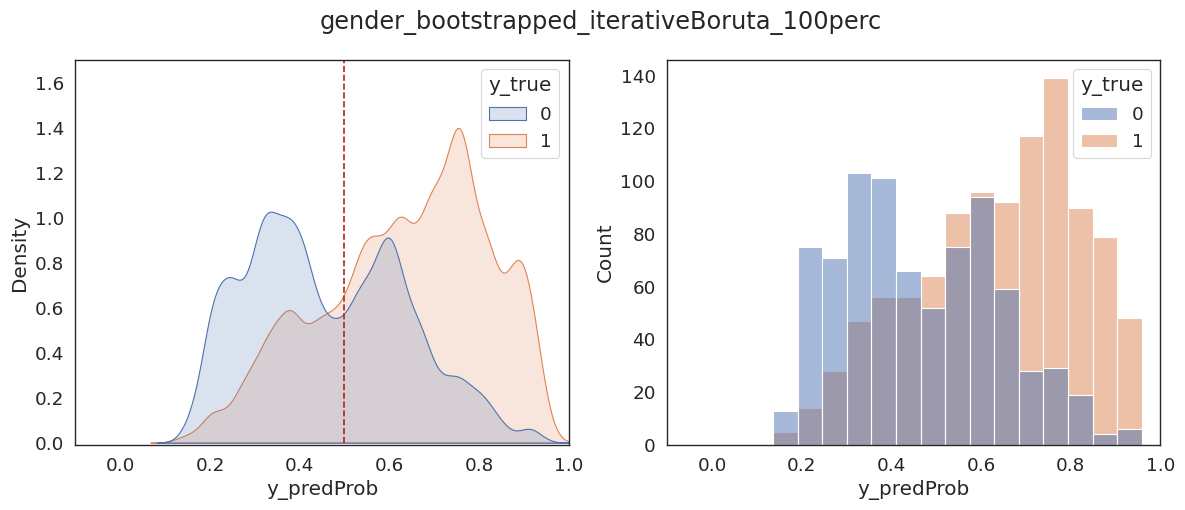

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.kdeplot(data=df_pred, x="y_predProb", bw_adjust=0.5, hue="y_true", fill=True, common_norm=True, alpha=0.2, ax=ax1)
sns.histplot(data=df_pred, x="y_predProb", hue="y_true", ax=ax2)
ax1.vlines(0.5, 0,2, linestyles="dashed", color="firebrick")

ax1.set_xlim(-0.1,1)
ax1.set_ylim(-0.01,1.7)
ax2.set_xlim(-0.1,1)
fig.suptitle(f"{vars}")

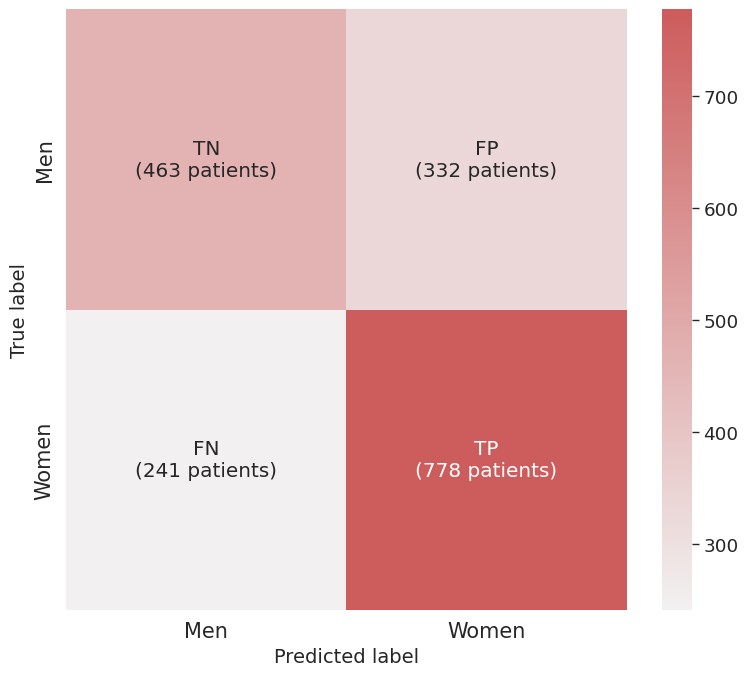

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

sns.set_theme(style="white", font_scale=1.5, context="paper")

cm = confusion_matrix(df_pred["y_true"], df_pred["y_predBinary"])

### Custom labels
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v2}\n({v1} patients)" for v1, v2 in zip(group_counts, group_names)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap=custom_cmap, ax=ax)

ax.xaxis.set_ticklabels(['Men', 'Women'], fontsize=15) 
ax.yaxis.set_ticklabels(['Men', 'Women'], fontsize=15)
ax.set_xlabel("Predicted label", fontsize=14)
ax.set_ylabel("True label", fontsize=14)

plt.tight_layout()
#plt.savefig(f"{folderFigures_publication}/confusionMatrix.pdf", dpi=300)

## Univariate tests between FN & TP women:

- continous values: `t.test`
- binary values: `chi2`

### Dissect women in FN and TP group

In [10]:
### FN women: in reality 1 but predicted as 0
women_fn = df_pred[(df_pred["y_true"] == 1) & (df_pred["y_predBinary"] == 0)]
print(women_fn.shape)
women_tp = df_pred[(df_pred["y_true"] == 1) & (df_pred["y_predBinary"] == 1)]
print(women_tp.shape)

(241, 3)
(778, 3)


In [11]:
#### Get variablse associated with each group
df_allVars_fn = df_reverseTransform.loc[women_fn.index,:]
df_allVars_fn["class"] = "fn"
df_allVars_tp = df_reverseTransform.loc[women_tp.index,:]
df_allVars_tp["class"] = "tp"

### Univariate test: continuous values (t.test / mann whitney u)

In [14]:
cont_columns = ['age_erstmanifestation', 'Diagnosedauer', 'scoreadl_neu', 
                'aktueller_mgfa_score', 'mgfaklassifikation_schlimmste_historisch_rb',
                'seelischesbefinden_neu', "chronicfatigue_normalised"]
df_cont_pval = pd.DataFrame(columns=cont_columns)

for i in cont_columns:
    pval = stat_continous(df_allVars_tp, df_allVars_fn, voi=i, plot=False, test="mannwhitneyu")
    mu_tp = df_allVars_tp[i].mean()
    std_tp = df_allVars_tp[i].std()
    mu_fn = df_allVars_fn[i].mean()
    std_fn =  df_allVars_fn[i].std()
    df_cont_pval[i] = pd.Series([mu_tp, std_tp, mu_fn, std_fn, pval])

### Plot overview of P-values
df_cont_pval = df_cont_pval.T
df_cont_pval.columns = ["mean_tp", "std_tp", "mean_fn", "std_fn","pValue"]
## correct for multiple testing
df_cont_pval["pValue_adj"] = false_discovery_control(df_cont_pval['pValue'], method='bh')
df_cont_pval.sort_values("pValue_adj")

### which ones under 0.05
df_cont_pval[df_cont_pval["pValue_adj"] < 0.05]

,mean_tp,std_tp,mean_fn,std_fn,pValue,pValue_adj
age_erstmanifestation,36.928643,17.393053,62.670397,11.699834,2.644250e-71,1.850975e-70
Diagnosedauer,2.745070,5.308258,0.882726,2.639858,2.692375e-14,9.423312e-14
scoreadl_neu,5.183774,3.727422,3.934886,3.214955,3.646087e-06,6.380651e-06
aktueller_mgfa_score,1.799486,0.840359,1.547718,0.916745,6.065441e-06,8.491618e-06
mgfaklassifikation_schlimmste_historisch_rb,2.928021,1.583363,2.406639,1.335648,1.367178e-05,1.595041e-05
seelischesbefinden_neu,12.700365,7.589877,11.205259,7.112646,1.220314e-02,1.220314e-02
chronicfatigue_normalised,0.538858,0.203864,0.463787,0.181002,8.312626e-08,1.939613e-07


In [59]:
df_allVars_fn

,age_erstmanifestation,Diagnosedauer,scoreadl_neu,seelischesbefinden_neu,chronicfatigue_normalised,gender,zn_myasthener_krise_jn,zn_myasthener_exazerbation,okulaer,bulbaer,...,eskalationstherapiebeitherapierefraktaerermyasthenie_grrb,eculizumab_sprb,rituximab_sprb,exazerbationstherapie_grrb,plasmapherese_sprb,immunadsorption_sprb,ivig_sprb,aktueller_mgfa_score,mgfaklassifikation_schlimmste_historisch_rb,class
04ULGGTR,58.0,0.0,2.0,7.000000,0.454545,1,0,0,1,0,...,0,0,0,0,0,0,0,2,2,fn
07C93JYK,73.0,1.0,2.0,7.870576,0.368758,1,0,0,1,1,...,0,0,0,0,0,0,0,2,5,fn
0Q09FRA9,42.0,0.0,2.0,3.000000,0.333333,1,0,0,1,1,...,0,0,0,0,0,0,0,0,3,fn
0RJH2UCL,74.0,0.0,5.0,11.000000,0.545455,1,0,0,1,1,...,0,0,0,0,0,0,0,0,3,fn
11N24VV0,75.0,0.0,1.0,1.500693,0.121212,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,fn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZA9N0YJ5,65.0,0.0,0.0,5.000000,0.424242,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,fn
ZADM8GU6,72.0,0.0,7.0,5.975051,0.398977,1,0,0,1,1,...,0,0,0,0,0,0,0,2,5,fn
ZR2G64WC,67.0,3.0,4.0,9.856095,0.828122,1,0,0,1,1,...,0,0,0,0,0,0,0,2,4,fn
ZRHGTRKF,62.0,0.0,4.0,17.000000,0.545455,1,0,0,1,1,...,0,0,0,0,0,0,0,2,3,fn


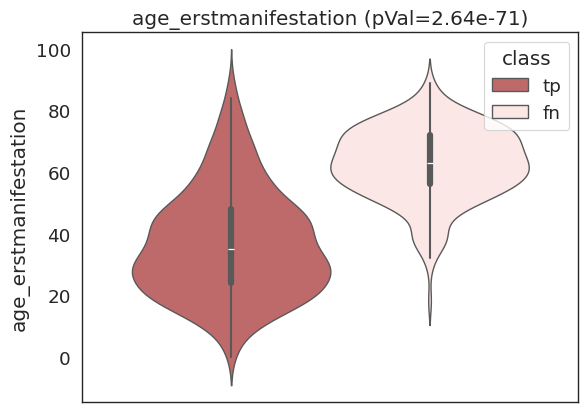

2.644250434659814e-71

In [60]:
stat_continous(df_allVars_tp, df_allVars_fn, voi="age_erstmanifestation", plot=True, colors = ["indianred", "mistyrose"])

### Univariate test: dichotomous values (chi2 contigency)

In [13]:
binary_cols = ["immuntherapie_grrb", "eskalationstherapiebeitherapierefraktaerermyasthenie_grrb",
               "exazerbationstherapie_grrb",
               "zn_myasthener_exazerbation","muskelschmerz",
               "autoimmunerkrankungen_rbzu",'achrak_rb', 'antimuskak_rb',
               'thymektomie_gr', 'pyridostigmin_sprb' ]
df_binary_pval = pd.DataFrame(columns=binary_cols)

for i in binary_cols: 
    pval = stat_binary(df_allVars_tp,
                df_allVars_fn,
                voi = i, 
                plot=False)
    df_binary_pval[i] = pd.Series(pval)

### Plot overview of P-values
df_binary_pval = df_binary_pval.T
df_binary_pval.columns = ["pValue"]
df_binary_pval["pValue_adj"] = false_discovery_control(df_binary_pval['pValue'], method='bh')
print(df_binary_pval.sort_values("pValue_adj"))

### which ones under 0.05
df_binary_pval[df_binary_pval["pValue_adj"] < 0.05]

                                                          pValue    pValue_adj
autoimmunerkrankungen_rbzu                          2.733799e-32  2.733799e-31
thymektomie_gr                                      8.711855e-22  4.355928e-21
eskalationstherapiebeitherapierefraktaerermyast...  4.344316e-04  1.448105e-03
exazerbationstherapie_grrb                          8.919821e-03  2.229955e-02
muskelschmerz                                       8.138982e-02  1.627796e-01
zn_myasthener_exazerbation                          2.691798e-01  4.486331e-01
antimuskak_rb                                       6.591122e-01  9.415889e-01
achrak_rb                                           7.902794e-01  9.878492e-01
immuntherapie_grrb                                  9.536550e-01  1.000000e+00
pyridostigmin_sprb                                  1.000000e+00  1.000000e+00


,pValue,pValue_adj
eskalationstherapiebeitherapierefraktaerermyasthenie_grrb,4.344316e-04,1.448105e-03
exazerbationstherapie_grrb,8.919821e-03,2.229955e-02
autoimmunerkrankungen_rbzu,2.733799e-32,2.733799e-31
thymektomie_gr,8.711855e-22,4.355928e-21


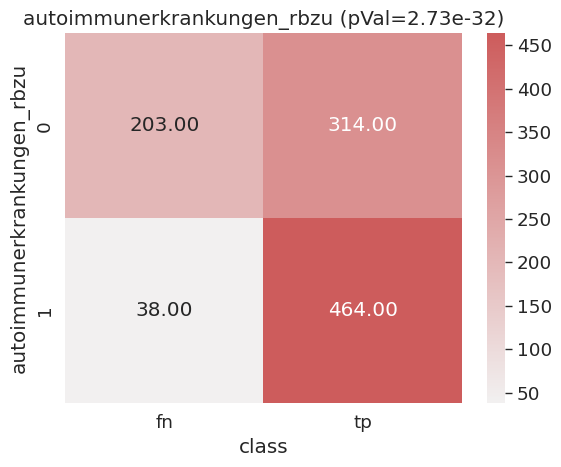

2.7337988096841504e-32

In [62]:
stat_binary(df_allVars_tp,
                df_allVars_fn,
                voi = "autoimmunerkrankungen_rbzu", 
                plot=True)

In [72]:
for i in binary_cols:
    print(i)
    mu_tp = df_allVars_tp[i].value_counts()
    mu_tp_perc = mu_tp / y.value_counts()[1]
    mu_fn = df_allVars_fn[i].value_counts()
    mu_fn_perc = mu_fn / y.value_counts()[1]
    print(f"{mu_tp[1]} ({round(mu_tp_perc[1],2)})")#; {mu_fn[1]} ({round(mu_fn_perc[1],2)})")
    print("\n")

immuntherapie_grrb
649 (0.64)


eskalationstherapiebeitherapierefraktaerermyasthenie_grrb
96 (0.09)


exazerbationstherapie_grrb
187 (0.18)


zn_myasthener_exazerbation
53 (0.05)


muskelschmerz
238 (0.23)


autoimmunerkrankungen_rbzu
464 (0.46)


achrak_rb
561 (0.55)


antimuskak_rb
74 (0.07)


thymektomie_gr
435 (0.43)


pyridostigmin_sprb
777 (0.76)




# Do FN women resemble TP men?

- if yes, how? 
- if no, what is different?

In [64]:
women_fn = df_pred[(df_pred["y_true"] == 1) & (df_pred["y_predBinary"] == 0)]
men_tp = df_pred[(df_pred["y_true"] == 0) & (df_pred["y_predBinary"] == 0)]

#### Get variablse associated with each group
df_allVars_fn = df_reverseTransform.loc[women_fn.index,:]
df_allVars_fn["class"] = "fn"

df_allVars_tp_men = df_reverseTransform.loc[men_tp.index,:]
df_allVars_tp_men["class"] = "tp_men"

In [65]:
df_allVars_fn

,age_erstmanifestation,Diagnosedauer,scoreadl_neu,seelischesbefinden_neu,chronicfatigue_normalised,gender,zn_myasthener_krise_jn,zn_myasthener_exazerbation,okulaer,bulbaer,...,eskalationstherapiebeitherapierefraktaerermyasthenie_grrb,eculizumab_sprb,rituximab_sprb,exazerbationstherapie_grrb,plasmapherese_sprb,immunadsorption_sprb,ivig_sprb,aktueller_mgfa_score,mgfaklassifikation_schlimmste_historisch_rb,class
04ULGGTR,58.0,0.0,2.0,7.000000,0.454545,1,0,0,1,0,...,0,0,0,0,0,0,0,2,2,fn
07C93JYK,73.0,1.0,2.0,7.870576,0.368758,1,0,0,1,1,...,0,0,0,0,0,0,0,2,5,fn
0Q09FRA9,42.0,0.0,2.0,3.000000,0.333333,1,0,0,1,1,...,0,0,0,0,0,0,0,0,3,fn
0RJH2UCL,74.0,0.0,5.0,11.000000,0.545455,1,0,0,1,1,...,0,0,0,0,0,0,0,0,3,fn
11N24VV0,75.0,0.0,1.0,1.500693,0.121212,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,fn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZA9N0YJ5,65.0,0.0,0.0,5.000000,0.424242,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,fn
ZADM8GU6,72.0,0.0,7.0,5.975051,0.398977,1,0,0,1,1,...,0,0,0,0,0,0,0,2,5,fn
ZR2G64WC,67.0,3.0,4.0,9.856095,0.828122,1,0,0,1,1,...,0,0,0,0,0,0,0,2,4,fn
ZRHGTRKF,62.0,0.0,4.0,17.000000,0.545455,1,0,0,1,1,...,0,0,0,0,0,0,0,2,3,fn


In [66]:
''' 
Univariate test: dichotomous values (chi2 contigency) 
'''

binary_cols = [
               "immuntherapie_grrb", "eskalationstherapiebeitherapierefraktaerermyasthenie_grrb","exazerbationstherapie_grrb",
               "zn_myasthener_exazerbation","muskelschmerz",
               "autoimmunerkrankungen_rbzu",'achrak_rb', 'antimuskak_rb',
               'thymektomie_gr', 'pyridostigmin_sprb']
df_binary_pval = pd.DataFrame(columns=binary_cols)

for i in binary_cols: 
    pval = stat_binary(df_allVars_tp_men,
                df_allVars_fn,
                voi = i, 
                plot=False)
    df_binary_pval[i] = pd.Series(pval)

### Plot overview of P-values
df_binary_pval = df_binary_pval.T
df_binary_pval.columns = ["pValue"]
df_binary_pval["pValue_adj"] = false_discovery_control(df_binary_pval['pValue'], method='bh')
print(df_binary_pval.sort_values("pValue_adj"))

### which ones under 0.05
df_binary_pval[df_binary_pval["pValue_adj"] < 0.05]

#######################################

''' 
Univariate test: continuous values (t.test)
'''

cont_columns = ['age_erstmanifestation', 'Diagnosedauer', 'scoreadl_neu', "chronicfatigue_normalised",
                'aktueller_mgfa_score','mgfaklassifikation_schlimmste_historisch_rb', 'seelischesbefinden_neu']
df_cont_pval = pd.DataFrame(columns=cont_columns)

for i in cont_columns:
    pval = stat_continous(df_allVars_tp_men, df_allVars_fn, voi=i, plot=False)
    mu_tp = df_allVars_tp_men[i].mean()
    std_tp = df_allVars_tp_men[i].std()
    mu_fn = df_allVars_fn[i].mean()
    std_fn =  df_allVars_fn[i].std()
    df_cont_pval[i] = pd.Series([mu_tp, std_tp, mu_fn, std_fn, pval])

### Plot overview of P-values
df_cont_pval = df_cont_pval.T
df_cont_pval.columns = ["mean_tp", "std_tp", "mean_fn", "std_fn","pValue"]
## correct for multiple testing
df_cont_pval["pValue_adj"] = false_discovery_control(df_cont_pval['pValue'], method='bh')
#print(df_cont_pval.sort_values("pValue_adj"))

df_cont_pval

### which ones under 0.05
#df_cont_pval[df_cont_pval["pValue_adj"] < 0.05]

                                                      pValue  pValue_adj
achrak_rb                                           0.000003    0.000026
autoimmunerkrankungen_rbzu                          0.001626    0.008129
antimuskak_rb                                       0.009662    0.032208
immuntherapie_grrb                                  0.153883    0.307765
thymektomie_gr                                      0.136166    0.307765
exazerbationstherapie_grrb                          0.195299    0.325499
muskelschmerz                                       0.329691    0.447835
pyridostigmin_sprb                                  0.358268    0.447835
eskalationstherapiebeitherapierefraktaerermyast...  1.000000    1.000000
zn_myasthener_exazerbation                          1.000000    1.000000


,mean_tp,std_tp,mean_fn,std_fn,pValue,pValue_adj
age_erstmanifestation,64.592584,11.038164,62.670397,11.699834,0.040654,0.092118
Diagnosedauer,0.630976,1.625695,0.882726,2.639858,0.003184,0.022291
scoreadl_neu,3.354845,3.017008,3.934886,3.214955,0.020862,0.073019
chronicfatigue_normalised,0.451081,0.177570,0.463787,0.181002,0.596575,0.638852
aktueller_mgfa_score,1.468683,0.871998,1.547718,0.916745,0.375947,0.526325
mgfaklassifikation_schlimmste_historisch_rb,2.475162,1.696357,2.406639,1.335648,0.638852,0.638852
seelischesbefinden_neu,10.201464,7.079971,11.205259,7.112646,0.052639,0.092118


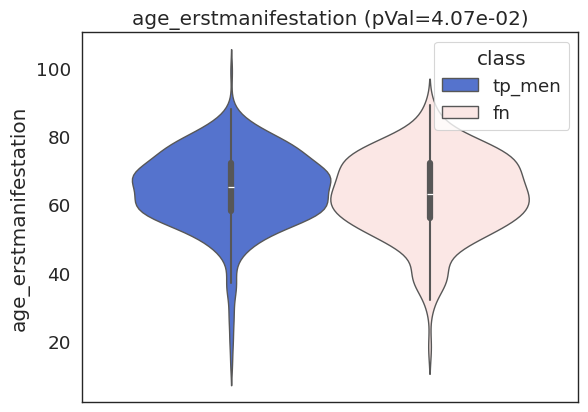

0.04065419769159953

In [67]:
stat_continous(df_allVars_tp_men, df_allVars_fn, voi="age_erstmanifestation", plot=True, colors = ["royalblue", "mistyrose"])

In [70]:
for i in binary_cols:
    print(i)
    mu_tp = df_allVars_tp_men[i].value_counts()
    mu_tp_perc = mu_tp / y.value_counts()[0]
    mu_fn = df_allVars_fn[i].value_counts()
    mu_fn_perc = mu_fn / y.value_counts()[1]
    print(f"{mu_tp[1]} ({round(mu_tp_perc[1],2)}); {mu_fn[1]} ({round(mu_fn_perc[1],2)})")
    print("\n")

immuntherapie_grrb
404 (0.51); 200 (0.2)


eskalationstherapiebeitherapierefraktaerermyasthenie_grrb
19 (0.02); 10 (0.01)


exazerbationstherapie_grrb
93 (0.12); 38 (0.04)


zn_myasthener_exazerbation
20 (0.03); 11 (0.01)


muskelschmerz
97 (0.12); 59 (0.06)


autoimmunerkrankungen_rbzu
36 (0.05); 38 (0.04)


achrak_rb
398 (0.5); 171 (0.17)


antimuskak_rb
16 (0.02); 20 (0.02)


thymektomie_gr
72 (0.09); 49 (0.05)


pyridostigmin_sprb
459 (0.58); 241 (0.24)




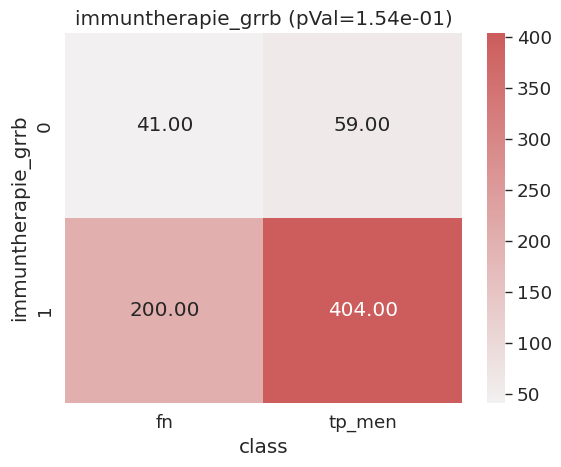

0.15388272812362594

In [69]:
stat_binary(df_allVars_tp_men, df_allVars_fn, voi="immuntherapie_grrb", plot=True)